## Face Recognition

Let's take a look at the facial recognition problem. We will use the Labeled Faces in the Wild dataset, which consists of several thousand collated photos of various public figures. A fetcher for the dataset is built into Scikit-Learn

In [1]:
%matplotlib inline
import numpy as np
import matplotlib.pyplot as plt
from scipy import stats

import torch
import torch.nn as N
import torch.nn.functional as F
import torch.optim as optim
import seaborn
device = torch.device("cuda:0" if torch.cuda.is_available() else "cpu")
print(device)

cuda:0


# Let's plot a few of these faces to see who we're working with:

face image shape: (nsamples, size_y, size_x)= (1348, 62, 47)
['Ariel Sharon' 'Colin Powell' 'Donald Rumsfeld' 'George W Bush'
 'Gerhard Schroeder' 'Hugo Chavez' 'Junichiro Koizumi' 'Tony Blair']


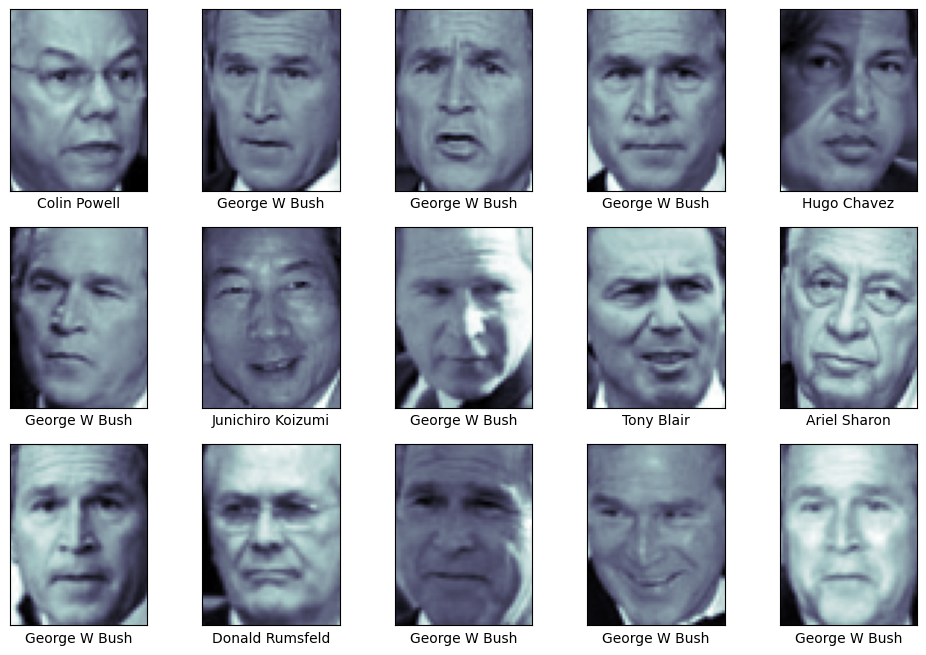

In [2]:
from sklearn.datasets import fetch_lfw_people
faces = fetch_lfw_people(min_faces_per_person=60)
print("face image shape: (nsamples, size_y, size_x)=", faces.images.shape)

print(faces.target_names)
fig, ax = plt.subplots(3, 5, figsize=(12,8))
for i, axi in enumerate(ax.flat):
    axi.imshow(faces.images[i], cmap='bone')
    axi.set(xticks=[], yticks=[],
            xlabel=faces.target_names[faces.target[i]])

In [3]:
from sklearn.model_selection import train_test_split
Xtrain, Xtest, ytrain, ytest = train_test_split(faces.data, faces.target,
                                                random_state=42)

# Define the neural network

Define


1.   a fully connected network with two hidden layers with Nh1 and Nh2 features, respectively. The hidden layers should use relu activation and the final layer <font color=red>should not have any activation.</font>
2.   a linear network with no hidden layer. We will use this network to study the benefit of depth, or equivalently using a non-linear network instead of a linear network. The final layer <font color=red>should not have any activation</font>


<font color=red>YOUR CODE BELOW </font>



In [10]:
class NeuralNet(N.Module):
    # YOUR CODE HERE
    def __init__(self,Nfeatures,Noutput,Nh1=10,Nh2=10):
        super(NeuralNet, self).__init__()
        # YOUR CODE HERE
        self.fc1 = N.Linear(Nfeatures, Nh1, bias=False) # Put input size here
        self.fc2 = N.Linear(Nh1, Nh2, bias=False)
        self.fc3 = N.Linear(Nh2, Noutput, bias=False) # Put output size here

    def forward(self, x):
        # YOUR CODE HERE
        x = self.fc1(x)
        x = F.relu(x)
        x = self.fc2(x)
        x = F.relu(x)
        x = self.fc3(x)
        return x

class LinearNet(N.Module):
    #YOUR CODE HERE
    def __init__(self,Nfeatures,Noutput):
        super(LinearNet, self).__init__()
        # YOUR CODE HERE
        self.fc1 = N.Linear(Nfeatures, Noutput, bias=False)     # Put input size here

    def forward(self, x):
        # YOUR CODE HERE
        x = self.fc1(x)
        return x

## Scale the features and convert the class labels to one hot encoding

ytrain  is a matrix of size Nsamplesx1, which are integers representing the class labels. We will convert them to one hot encoding. In particular y_train_T will be a matrix of NsamplesxNclasses, where y_train_T[i,:] is a binary vector of size 1xNclasses, which indicates the specific class the ith sample belong to.

In [18]:
# Scaling features to have a maximum value of 1; grayscale images have value between 0 and 255
featureScale = 255
Nfeatures = Xtrain.shape[1]
X_train_T = Xtrain/featureScale
X_train_T = torch.tensor(X_train_T.astype(np.float32)).to(device)

# Converting to one hot vectors
y_train_l = torch.tensor(ytrain).to(device)
y_train_T = torch.nn.functional.one_hot(y_train_l)
y_train_T = y_train_T.type(torch.float)

Nclasses = np.max(ytrain)+1

## Train the network using Cross entropy loss

See https://pytorch.org/docs/stable/generated/torch.nn.CrossEntropyLoss.html for details. It expects an input of size Nsamples x Nclasses, which is un-normalized logits, and a target, which is y_train_l of size Nsamplesx1. You may also feed it y_train_T of size Nsample x Nclasses. Please see the documentation.

Cross entropy loss expects raw unnrormalized scores. Soft-max converts raw unnormalized scores to probabilities, which are used to plot the labels.


<font color=red> Use SGD and run 20,000 epochs using a learning rate of 1e-2 to train the neural network </font>

Error = 16.635498046875


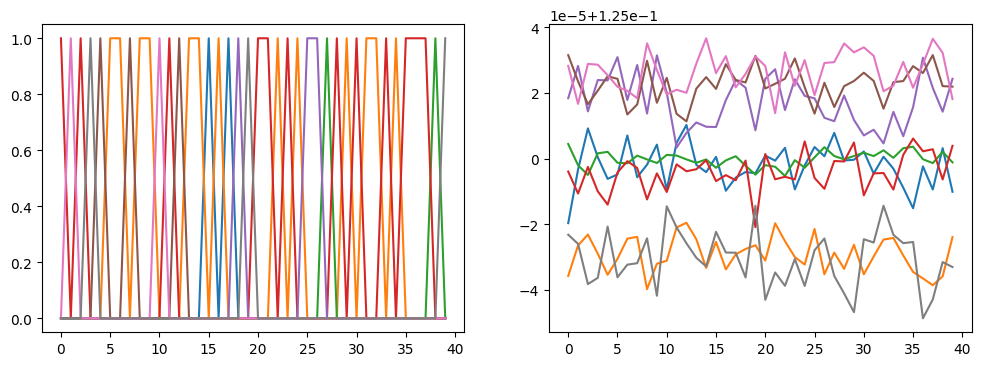

Error = 5.384523868560791


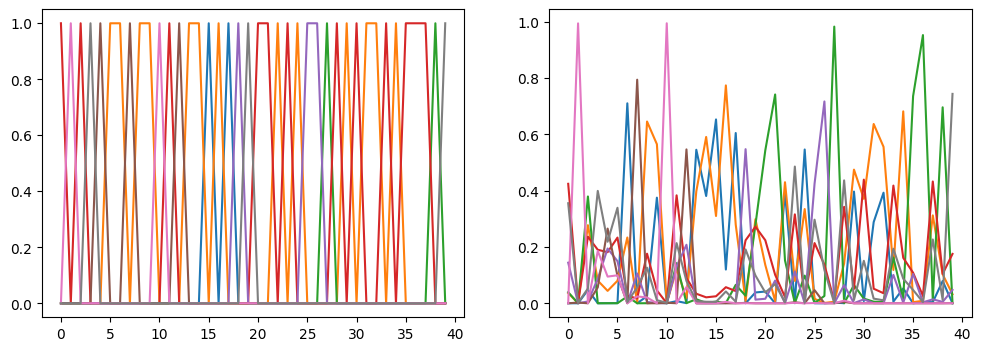

Error = 5.896098613739014


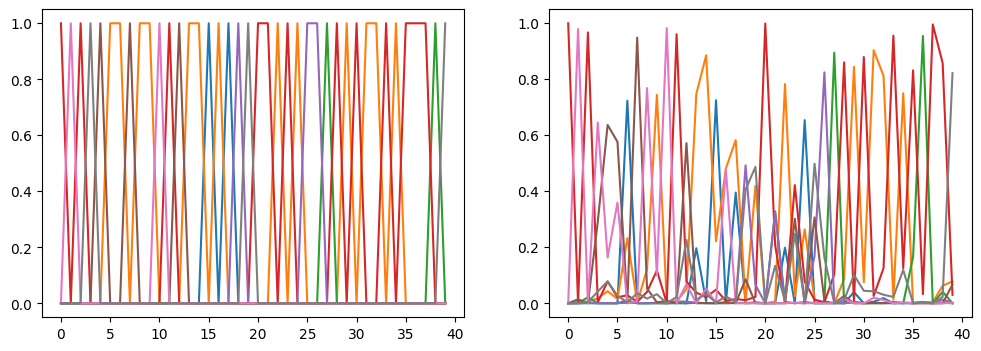

Error = 2.653902292251587


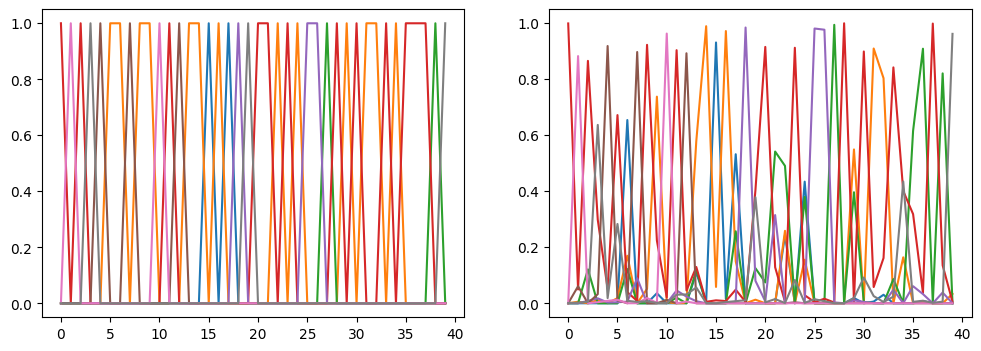

In [19]:
nn = NeuralNet(Nfeatures,Nclasses,20,20).to(device)
sm = N.Softmax(dim=1)

# Weight the cross entropy loss to balance the classes
Nsamples_per_class = y_train_T.sum(axis=0)
Weight = Nsamples_per_class.sum()/Nsamples_per_class
loss = torch.nn.CrossEntropyLoss(weight=Weight)

#YOUR CODE HERE
learning_rate = 0.1
optimizer= torch.optim.SGD(nn.parameters(), lr=learning_rate) # define optimizer

for epoch in range(20000):

    #YOUR CODE HERE
    predNN = nn.forward(X_train_T)   # Forward pass
    error = loss(predNN, y_train_T)  # find the loss
    optimizer.zero_grad()            # clear the gradients
    error.backward()                 # Send loss backward
    optimizer.step()                 # update weights

    if(np.mod(epoch,5000)==0):
      print("Error =",error.detach().cpu().item())
      fig,ax = plt.subplots(1,2,figsize=(12,4))
      ax[0].plot(y_train_T[0:40].detach().cpu())
      ax[1].plot(sm(predNN[0:40]).detach().cpu())
      plt.show()

# Train the linear network


<font color=red> Use SGD and run 20,000 epochs using a learning rate of 1e-2 to train the neural network </font>

Error = 16.63558578491211


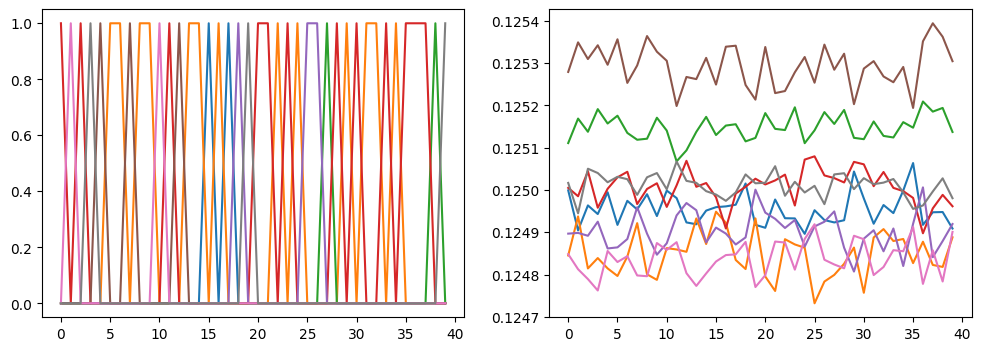

Error = 16.4213924407959


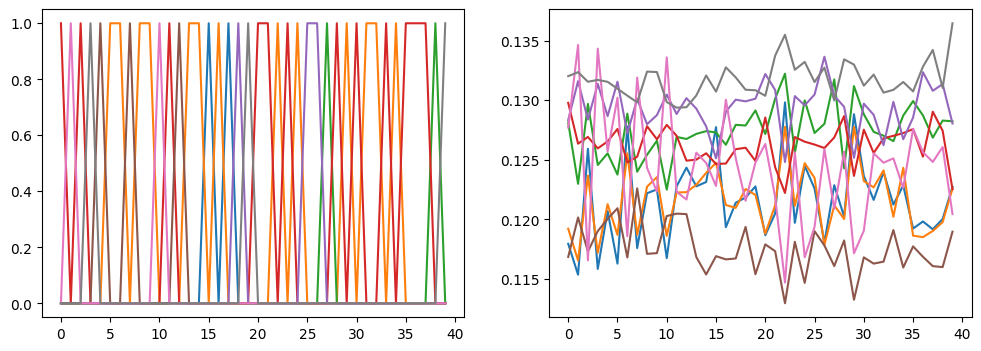

Error = 16.219499588012695


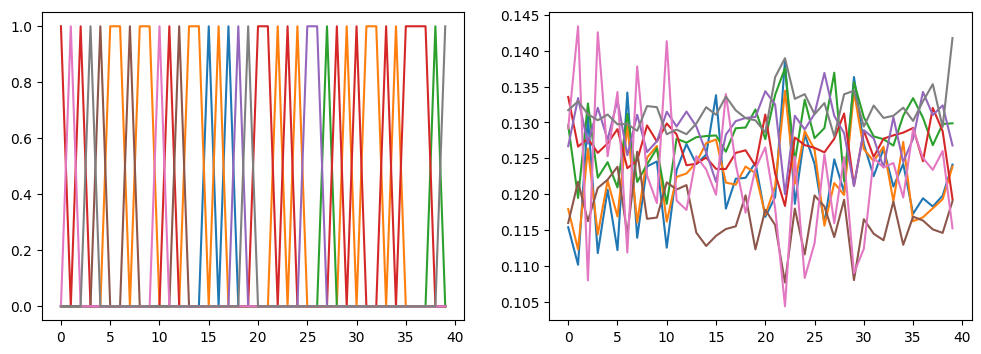

Error = 16.024642944335938


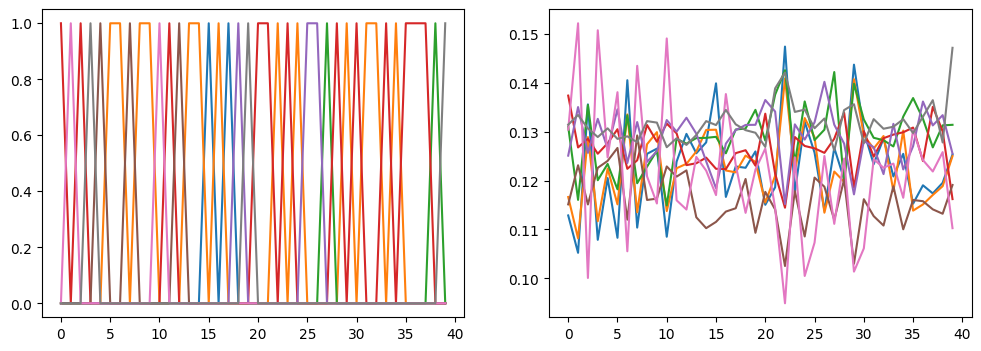

In [20]:
ln = LinearNet(Nfeatures,Nclasses).to(device)
sm = N.Softmax(dim=1)

# Weight the cross entropy loss to balance the classes
Nsamples_per_class = y_train_T.sum(axis=0)
Weight = Nsamples_per_class.sum()/Nsamples_per_class
loss = torch.nn.CrossEntropyLoss(weight=Weight)

#YOUR CODE HERE
optimizer= torch.optim.SGD(ln.parameters(), lr=learning_rate) # define optimizer

for epoch in range(20000):
    #YOUR CODE HERE
    predLN = ln.forward(X_train_T)   # Forward pass
    error = loss(predLN, y_train_T)  # find the loss
    optimizer.zero_grad()            # clear the gradients
    error.backward()                 # Send loss backward
    optimizer.step()                 # update weights

    if(np.mod(epoch,5000)==0):
      print("Error =",error.detach().cpu().item())
      fig,ax = plt.subplots(1,2,figsize=(12,4))
      ax[0].plot(y_train_T[0:40].detach().cpu())
      ax[1].plot(sm(predLN[0:40]).detach().cpu())
      plt.show()

# Scale test data and test

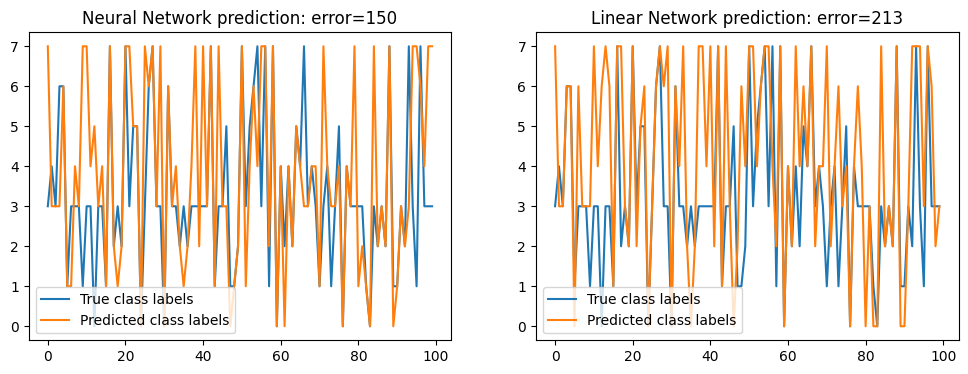

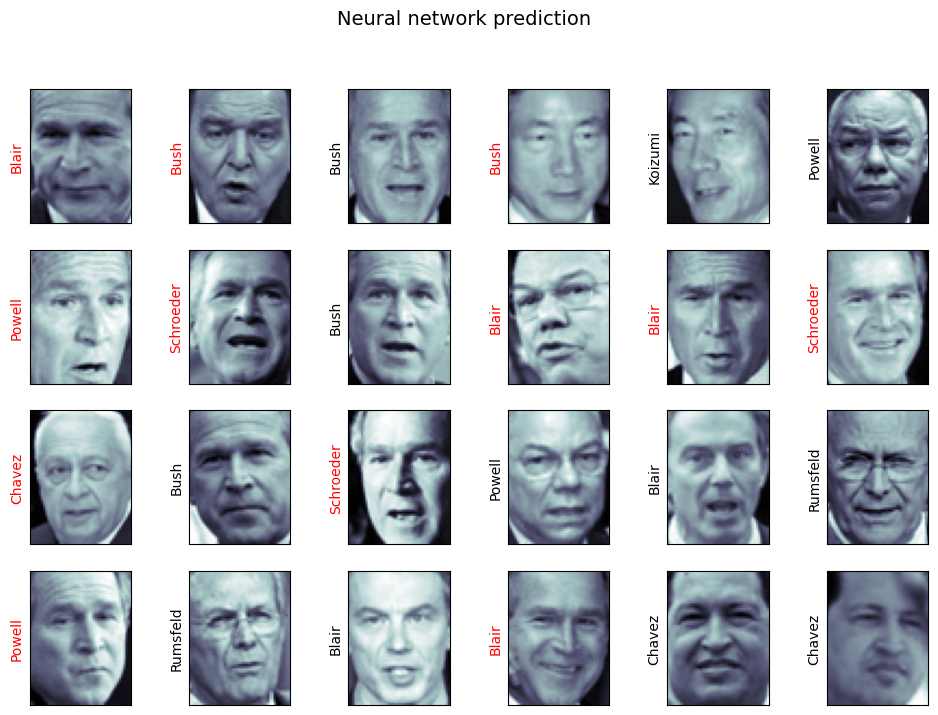

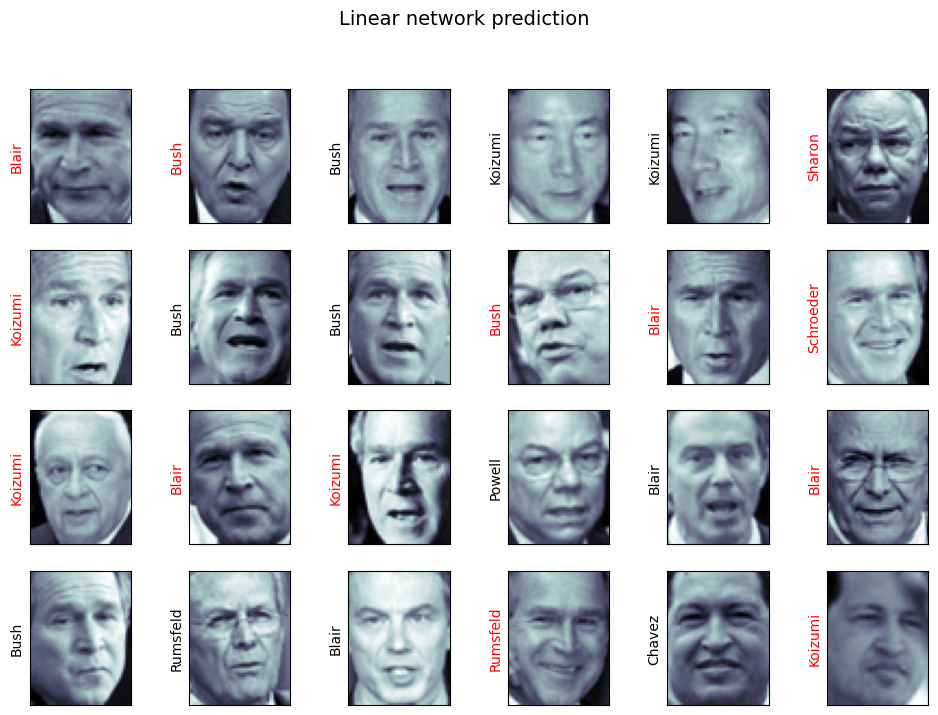

In [21]:
# Scaling features to have a maximum value of 1; grayscale images have value between 0 and 255
featureScale = 255
X_test_T = Xtest/featureScale
X_test_T = torch.tensor(X_test_T.astype(np.float32)).to(device)

# Converting to one hot vectors
y_test_l = torch.tensor(ytest).to(device)
y_test_T = torch.nn.functional.one_hot(y_test_l)


outNN = nn(X_test_T)
predicted_labels_NN = torch.argmax(sm(outNN.detach()), dim=1)

outLN = ln(X_test_T)
predicted_labels_LN = torch.argmax(sm(outLN.detach()), dim=1)

fig,ax = plt.subplots(1,2,figsize=(12,4))
ax[0].plot(ytest[0:100],label='True class labels')
ax[0].plot(predicted_labels_NN[0:100].cpu(),label='Predicted class labels')
ax[0].legend()
error = sum((predicted_labels_NN-y_test_l).abs()>0)
ax[0].set_title('Neural Network prediction: error='+str(error.item()))


ax[1].plot(ytest[0:100],label='True class labels')
ax[1].plot(predicted_labels_LN[0:100].cpu(),label='Predicted class labels')
ax[1].legend()
error = sum((predicted_labels_LN-y_test_l).abs()>0)
ax[1].set_title('Linear Network prediction: error='+str(error.item()))

plt.show()


fig, ax = plt.subplots(4, 6, figsize=(12,8))
for i, axi in enumerate(ax.flat):
    axi.imshow(Xtest[i].reshape(62, 47), cmap='bone')
    axi.set(xticks=[], yticks=[])
    axi.set_ylabel(faces.target_names[predicted_labels_NN[i]].split()[-1],
                   color='black' if predicted_labels_NN[i] == ytest[i] else 'red')
fig.suptitle('Neural network prediction', size=14);

fig, ax = plt.subplots(4, 6, figsize=(12,8))
for i, axi in enumerate(ax.flat):
    axi.imshow(Xtest[i].reshape(62, 47), cmap='bone')
    axi.set(xticks=[], yticks=[])
    axi.set_ylabel(faces.target_names[predicted_labels_LN[i]].split()[-1],
                   color='black' if predicted_labels_LN[i] == ytest[i] else 'red')
fig.suptitle('Linear network prediction', size=14);

We might also display the confusion matrix between these classes:

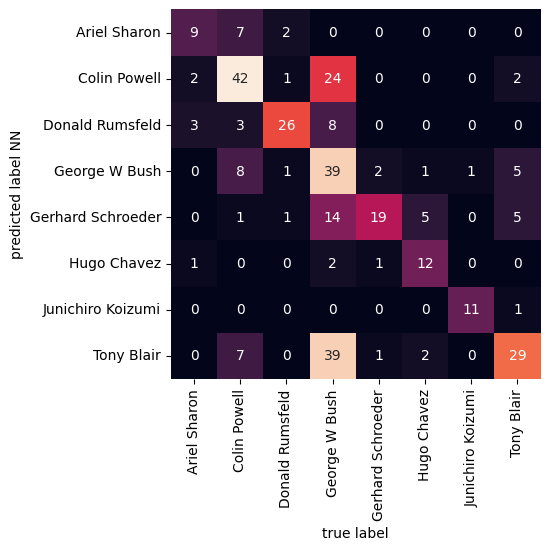

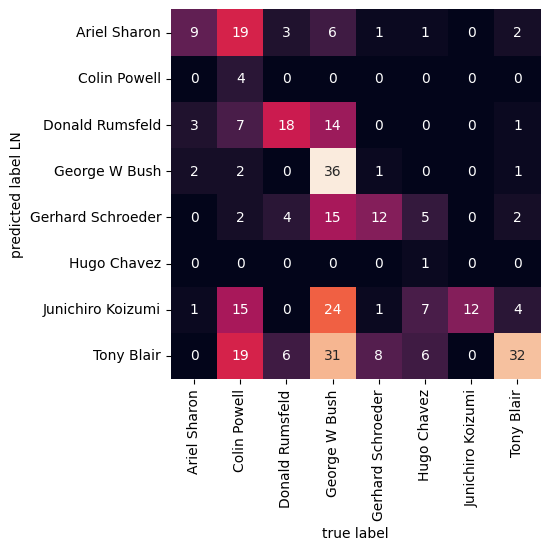

In [22]:
from sklearn.metrics import confusion_matrix
mat = confusion_matrix(ytest, predicted_labels_NN.cpu().numpy())
seaborn.heatmap(mat.T, square=True, annot=True, fmt='d', cbar=False,
            xticklabels=faces.target_names,
            yticklabels=faces.target_names)
plt.xlabel('true label')
plt.ylabel('predicted label NN');

plt.figure()
from sklearn.metrics import confusion_matrix
mat = confusion_matrix(ytest, predicted_labels_LN.cpu().numpy())
seaborn.heatmap(mat.T, square=True, annot=True, fmt='d', cbar=False,
            xticklabels=faces.target_names,
            yticklabels=faces.target_names)
plt.xlabel('true label')
plt.ylabel('predicted label LN');

This helps us get a sense of which labels are likely to be confused by the estimator.

For a real-world facial recognition task, in which the photos do not come pre-cropped into nice grids, the only difference in the facial classification scheme is the feature selection: you would need to use a more sophisticated algorithm to find the faces, and extract features that are independent of the pixellation.
For this kind of application, one good option is to make use of [OpenCV](http://opencv.org), which, among other things, includes pre-trained implementations of state-of-the-art feature extraction tools for images in general and faces in particular.